## lib Loading

In [299]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from si_prefix import si_format

## Grand plans

### Junction project

- Fab SQUID chain with $E_J 200mK, E_C 8mK$ **(Q1D078)**
- Fab  SQUID chain with $E_J 4K, E_C 8mK$ to study $E_J$ cross-over **(Q1D074_N4)**
- Study noise reduction
    - better V source
    - better filters
        - Commercial LP filters
        - Add $1M\Omega$ metal film resistor on sample holder
    - Check noise spectrum with low $f$ range oscilloscope 

### Bi-fluxon project

grAl bi-fluxon with $5 \times 25\mu m^2, \mu H$ level superinductor

### HIM project

- Complete $T_C$-dome for grAl before / after $He^{+}$ irradiation

<IPython.core.display.Javascript object>


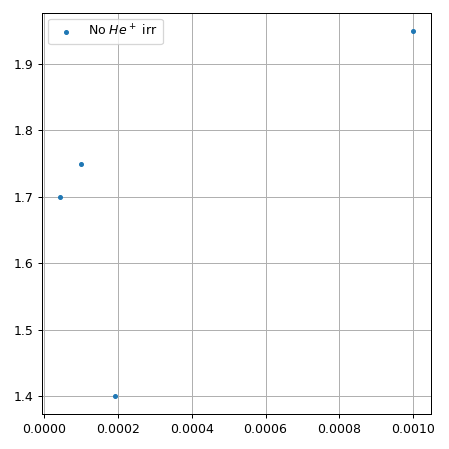

In [105]:
Tc  = [     1.4,    1.7,   1.75,   1.95,     ]
rho = [ 19.2e-5, 4.2e-5, 9.9e-5, 100e-5,     ]

plt.close('all')
f,ax = plt.subplots(figsize=(5, 5))
ax.plot(rho,Tc,'.', label='No $He^+$ irr')
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


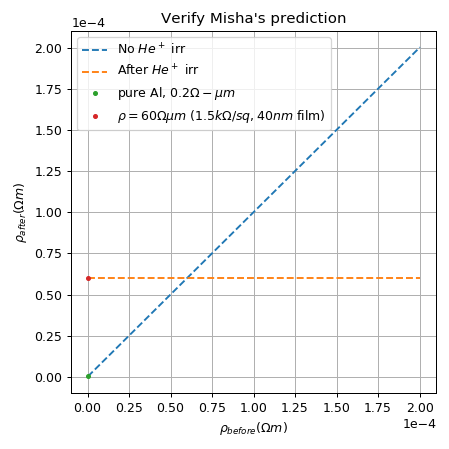

In [88]:
x = np.linspace(0.2e-6, 200.2e-6, 201)
y_bf = x
y_pure = 0.2e-6
y_amor =  60e-6
y_af = np.full(201, y_amor)

plt.close('all')
f,ax = plt.subplots(figsize=(5, 5))
ax.plot(x,y_bf,ls='--', label='No $He^+$ irr')
ax.plot(x,y_af,ls='--', label='After $He^+$ irr')
ax.plot(y_pure,y_pure, '.', label='pure Al, $0.2\Omega-\mu m$')
ax.plot(y_pure,y_amor, '.', label=r'$\rho = 60\Omega\mu m$ ($1.5k\Omega/sq,40nm$ film)')
ax.title.set_text('Verify Misha\'s prediction')
ax.set_xlabel(r'$\rho_{before} (\Omega m)$')
ax.set_ylabel(r'$\rho_{after} (\Omega m)$')
ax.ticklabel_format(axis='both', style='sci', scilimits=(0, 2))
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

## To Do list
- LS370 still crashes after around 7hrs continuous operation
- Make new cables
    - Remake the I, V splitting Fisher probing line
    - Remake ISO, COM x2 Fisher-BNC cables
- Maintain old sample holder
    - Fix pin 5b
- Try to see if we can fix the wiring in the fridge. Currently ch 5ab open, ch 10ab short.
- Make new sample holder

## Update RTc for T8>102K

Locate files "CH8 T dd-mm-yy.log" and "CH0 T dd-mm-yy.log" under below path:

C:\Users\KelvinOX25\Documents\GitHub\measDC

Copy them to below path:

\\SERIN135_DR-PC\BlueFors\Temperature Log\dd-mm-yy

Then run below two cells

In [3]:
import time, datetime

def getTt(rootpath, filedate = '21-11-19', Tch = 0):
    filename = r'\\'+filedate+'\CH{} T '.format(Tch)+filedate+'.log'
    filepath = rootpath+filename

    dateori = datetime.datetime(2019,11,21,0,0,0)
    dhrslst = []
    dlst = []
    Tlst = []
    with open(filepath) as fp:
        line = fp.readline()
        cnt = 1
        while line:
            l = line.strip()
            d = datetime.datetime(int(l.split(',')[0].split('-')[2])+2000,
                                  int(l.split(',')[0].split('-')[1]),
                                  int(l.split(',')[0].split('-')[0]),
                                  int(l.split(',')[1].split(':')[0]),
                                  int(l.split(',')[1].split(':')[1]),
                                  int(l.split(',')[1].split(':')[2]))
            T = float(l.split(',')[2])
            dhrslst.append(((d-dateori).days *86400 + (d-dateori).seconds)/60/60)
            dlst.append(d)
            Tlst.append(T)
            line = fp.readline()
            cnt += 1
    fp.close()
    return (dhrslst, dlst, Tlst)

def fillDataGap(ref_x1, gapped_x2, gapped_y2):
    filled_y2 = np.full_like(np.arange(len(ref_x1)),np.nan, dtype=np.double)
    for i,v2 in enumerate(gapped_x2):
        for j,v1 in enumerate(ref_x1):
            vt1 = v1.year*525600 + v1.month*43800 + v1.day*1440 + v1.hour*60 + v1.minute
            vt2 = v2.year*525600 + v2.month*43800 + v2.day*1440 + v2.hour*60 + v2.minute
            if vt2 == vt1:
                filled_y2[j]= gapped_y2[i]
                break
    return filled_y2

<IPython.core.display.Javascript object>


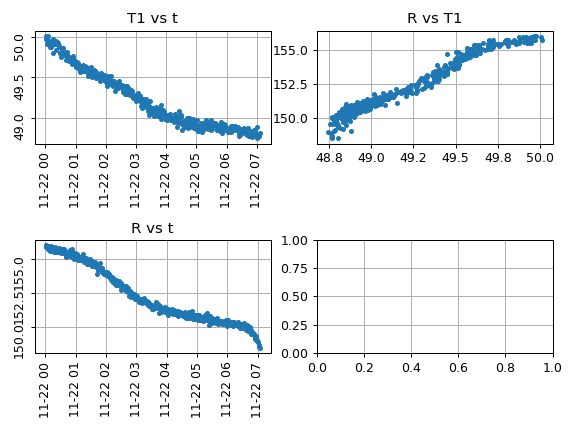

In [20]:
rootpath = r'\\SERIN135_DR-PC\BlueFors\Temperature Log'
filedate = '22-11-19'
dhrslst1, dlst1, Tlst1 = getTt(rootpath=rootpath, filedate = filedate, Tch = 1)
dhrslstR, dlstR, TlstR = getTt(rootpath=rootpath, filedate = filedate, Tch = 0)

TlstRnew = fillDataGap(ref_x1 = dlst1, gapped_x2 = dlstR, gapped_y2 = TlstR)
plt.close('all')
f,ax = plt.subplots(2,2)
ax[0][0].plot(dlst1,Tlst1,'.')
ax[0][0].set_title('T1 vs t')
ax[0][0].tick_params(labelrotation=90)

ax[1][0].plot(dlstR,TlstR,'.')
ax[1][0].set_title('R vs t')
ax[1][0].tick_params(labelrotation=90)

ax[0][1].plot(Tlst1,TlstRnew,'.')
from matplotlib.ticker import FormatStrFormatter
ax[0][1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0][1].set_title('R vs T1')


for i in [0,1]:
    for j in [0,1]:
        ax[i][j].grid()

plt.tight_layout()
plt.show()

## Realtime data visualization

In [2]:
import qcodes as qc
from qcodes.dataset.database import initialise_database
from qcodes.dataset.plotting import plot_by_id, get_data_by_id, plot_dataset

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\qcodes\dataset\database.py:13: UserWarning: The module `qcodes.dataset.database` is deprecated.
Public features are available at the import of `qcodes`.
Private features are available in `qcodes.dataset.sqlite.*` modules.
  warnings.warn('The module `qcodes.dataset.database` is deprecated.\n'


<IPython.core.display.Javascript object>


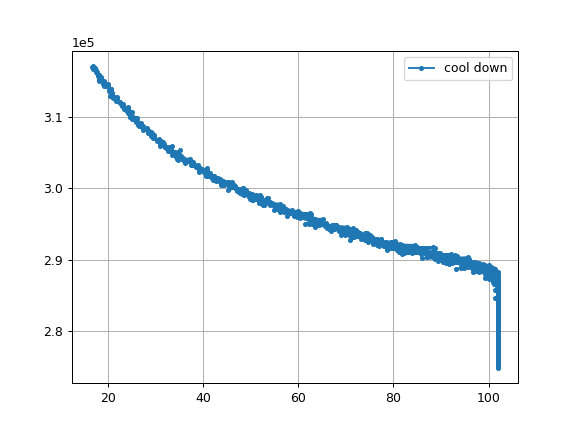

In [13]:
SAMPLE = 'aka5bN1'#site9 actually
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots()
label = ['cool down',
         'cool down',
         'warm up',
         'cool down',
         'warm up']

for i,v in enumerate([27]):#,32
    data = get_data_by_id(v)
    T = data[0][0]['data']
#     T = np.linspace(1,len(data[0][0]['data']),len(data[0][0]['data']))
    R = data[0][1]['data']

    ax.plot(T, R, '.',ls='-', label = label[i])# 

ax.legend()
ax.grid()
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 2))

<IPython.core.display.Javascript object>


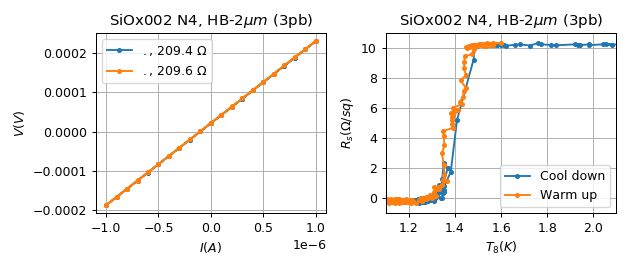

In [108]:
SAMPLE = 'O2N4' #1ab,1a2b
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(7,3))

devW, devL, devTHK = 3.06e-6, 12.2e-6, 48e-9
Rs0 = 12.5

labelL = ['$.$',
          '$.$']
for i,v in enumerate([8,11]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].legend()
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].title.set_text('SiOx002 N4, HB-$2\mu m$ (3pb)')
ax[0].grid()
ax[0].ticklabel_format(axis='x', style='sci', scilimits=(0, 2))

labelR = [#'from 300K',14,15,18,19
          'Cool down',
          'Warm up',
          'from 300K']
for i,v in enumerate([21,22]):
    data = get_data_by_id(v)
    T = data[0][0]['data'][:800]
    R = data[0][1]['data'][:800]
    Rs = R*devW/devL - Rs0
    ax[1].plot(T, Rs, '.',ls='-', label = labelR[i])#ls='-', alpha=1-0.99*i 

ax[1].legend()
ax[1].set_xlabel('$T_8 (K)$')
ax[1].set_ylabel('$R_s (\Omega/sq)$')
ax[1].title.set_text('SiOx002 N4, HB-$2\mu m$ (3pb)')
ax[1].set_ylim(-1,11)
ax[1].set_xlim(1.1,2.1)
ax[1].grid()
ax[1].ticklabel_format(axis='none', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


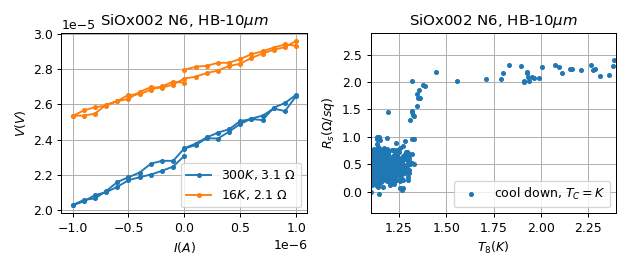

In [123]:
SAMPLE = 'O2N6' #3ab,4ab
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(7,3))

devW, devL, devTHK = 12.3e-6, 11.9e-6, 56e-9

labelL = ['$300K$',
          '$16K$']
for i,v in enumerate([4,6]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].legend()
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].title.set_text('SiOx002 N6, HB-$10\mu m$')
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

labelR = [#'from 300K',
          'cool down, $T_C = K$',
          'warm up']
for i,v in enumerate([7]):
    data = get_data_by_id(v)
    T = data[0][0]['data']
    R = data[0][1]['data']
    Rs = R*devW/devL
    ax[1].plot(T, Rs, '.', label = labelR[i])#ls='-', alpha=1-0.99*i 

ax[1].legend()
ax[1].set_xlabel('$T_8 (K)$')
ax[1].set_ylabel('$R_s (\Omega/sq)$')
ax[1].title.set_text('SiOx002 N6, HB-$10\mu m$')
ax[1].set_ylim(-0.4,2.9)
ax[1].set_xlim(1.1,2.4)
ax[1].grid()
ax[1].ticklabel_format(axis='none', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


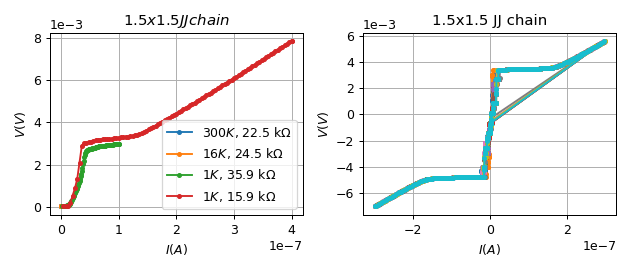

In [250]:
SAMPLE = '74N4' #6ab,9ba
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(7,3))

# devW, devL, devTHK = 1.51e-6, 17.9e-6, 40e-9

labelL = ['$300K$',
          '$16K$',
          '$1K$',
          '$1K$']
for i,v in enumerate([1,2,3,4]):
    data = get_data_by_id(v)
    Is = data[0][0]['data'][int(len(data[0][0]['data'])/4):int(2*len(data[0][0]['data'])/4)]
    Vs = data[0][1]['data'][int(len(data[0][1]['data'])/4):int(2*len(data[0][1]['data'])/4)]
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].legend()
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].title.set_text('$1.5x1.5 JJ chain$')
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

labelR = ['$cos(\phi)$=1',
          '$cos(\phi)$=1',
          '$cos(\phi)$=0...']
for i,v in enumerate(range(137,147)):#15,16,17,18,19,
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    ax[1].plot(Is, Vs, '.', ls='-', label = labelR[0])#ls='-', alpha=1-0.99*i 

# ax[1].legend()
ax[1].set_xlabel('$I(A)$')
ax[1].set_ylabel('$V(V)$')
ax[1].title.set_text('1.5x1.5 JJ chain')
# ax[1].set_xlim(0,1e-7)
# ax[1].set_ylim(-4e-4,4e-3)
ax[1].grid()
ax[1].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

In [484]:
ZF =  0.004e-3
FF =  0.224e-3
dF = 0.250e-3
midF = 0.154e-3
import pandas as pd
pd.set_option("display.precision", 3)

key = [                  'ids', 'T',    'B',                                  'Vthr', 'comments'        ]  
lst = [[              [8,9,10],  43e-3, [ZF,midF,FF]                        ,   4e-3, 'quick IVc meas'  ],  
       [                  [13],  43e-3, udu_list(amp=0.500e-3, stp=0.005e-3),   4e-3, ''                ],  
       [range(  22,   42+1)[:],  50e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range(  43,   63+1)[:], 100e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range(  64,   84+1)[:], 150e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range(  85,  105+1)[:], 200e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 106,  126+1)[:], 250e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 127,  147+1)[:], 300e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 148,  168+1)[:], 350e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 169,  189+1)[:], 400e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 190,  210+1)[:], 450e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 211,  231+1)[:], 500e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 232,  252+1)[:], 550e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 253,  262+1)[:],  43e-3,                               ZF    ,   4e-3, 'repeated IVc_ada'],  
#        [range( 263,  272+1)[:],  43e-3,                               ZF    ,   4e-3, 'repeated IVc'    ],  
       [range( 273,  282+1)[:],  43e-3,                               ZF    ,   4e-3, 'repeated IVc'    ]]    
        
exps = pd.DataFrame(  data = list(zip(*lst)), 
                   columns = range(len(lst)),
                     index = key )

exps.transpose()[exps.transpose()['T'] == 43e-3]['ids'].tolist()

[[8, 9, 10], [13], range(253, 263), range(273, 283)]

<IPython.core.display.Javascript object>


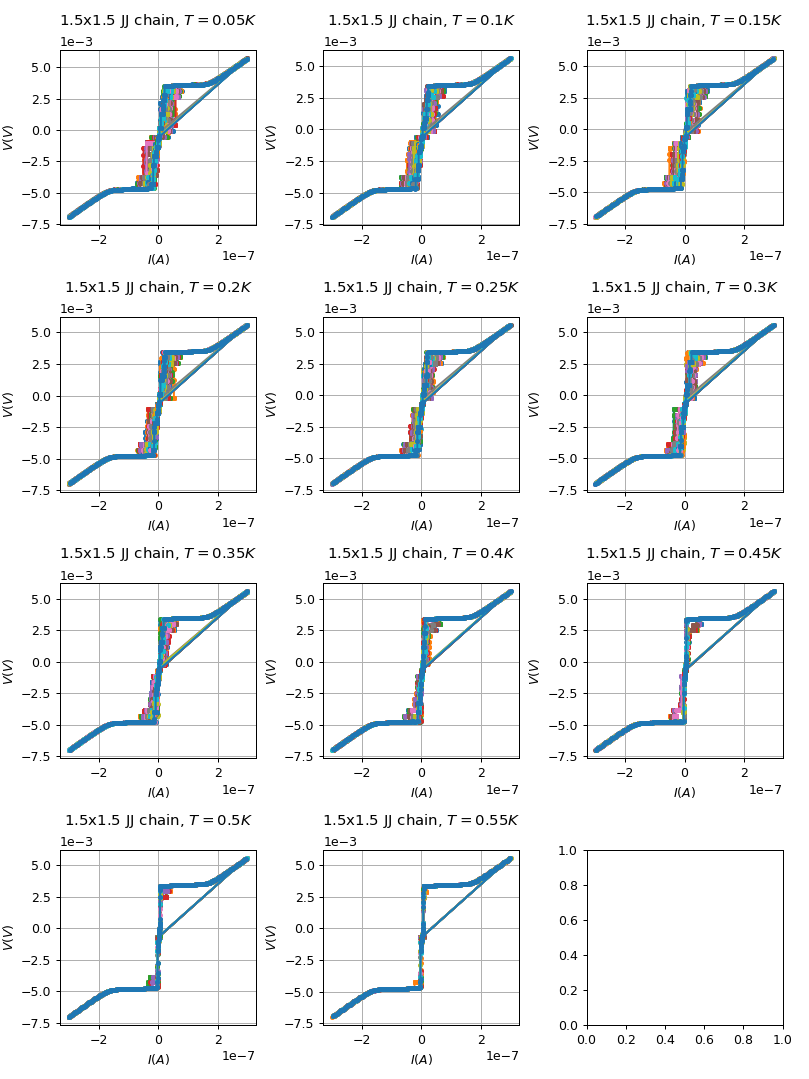

In [470]:
SAMPLE = '74N4' #6ab,9ba
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(4,3, figsize=(9,12))
ax = ax.flatten()

Tlst = [50e-3,100e-3,150e-3,200e-3,250e-3,300e-3,350e-3,400e-3,450e-3,500e-3,550e-3]
for j,T in enumerate(Tlst):
    idlst = exps.transpose()[exps.transpose()['T'] == T]['ids'].tolist()[0]
    for i,v in enumerate(idlst):
        data = get_data_by_id(v)
        Is = data[0][0]['data']
        Vs = data[0][1]['data']
        ax[j].plot(Is, Vs, '.', label = '$T={}K$'.format(si_format(T)))#ls='-',
    ax[j].grid()
    ax[j].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))
    ax[j].set_xlabel('$I(A)$')
    ax[j].set_ylabel('$V(V)$')
    ax[j].set_title('1.5x1.5 JJ chain, $T={}K$'.format(T), pad=20)
    ax[j].grid('both')
    ax[j].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


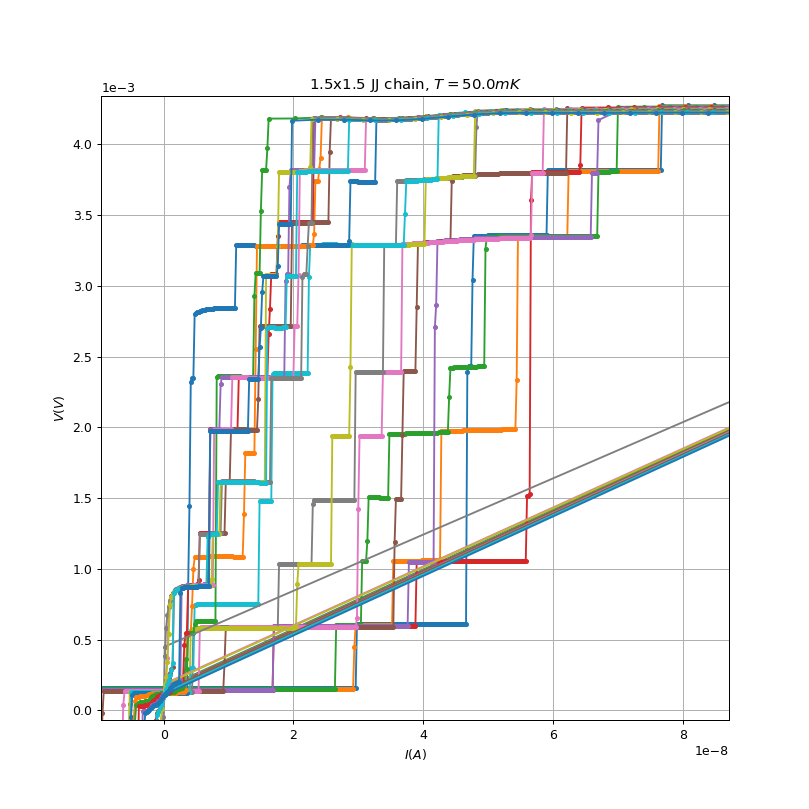

In [824]:
SAMPLE = '74N4' #6ab,9ba
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()

T = 50e-3
lst = exps.transpose()[exps.transpose()['T'] == T]['ids'].tolist()[0]

plt.close('all')
f,ax = plt.subplots(figsize=(9,9))

for i,v in enumerate(lst):#15,16,17,18,19,
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    
    Is_off =   2.05e-9
    Vs_off = -6.785e-4
    Is = Is-Is_off
    Vs = Vs-Vs_off

    ax.plot(Is, Vs, '.', ls='-', label = labelR[0])#ls='-', alpha=1-0.99*i 

# ax.legend()
ax.set_xlabel('$I(A)$')
ax.set_ylabel('$V(V)$')
ax.title.set_text('1.5x1.5 JJ chain, $T={}K$'.format(si_format(T)))
# ax.set_xlim(0,1e-7)
# ax.set_ylim(-4e-4,4e-3)
ax.grid()
ax.ticklabel_format(axis='both', style='sci', scilimits=(0, 2))


<IPython.core.display.Javascript object>


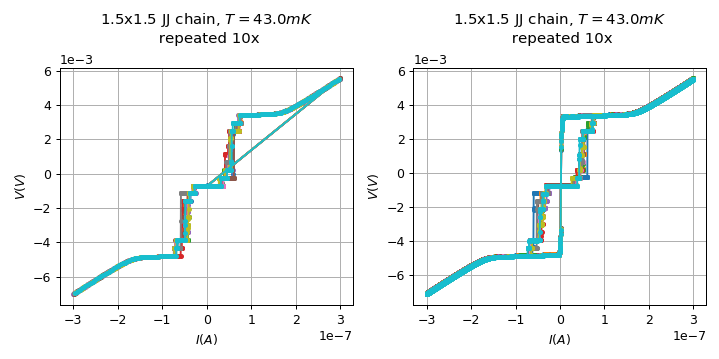

In [488]:
SAMPLE = '74N4' #6ab,9ba
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(8,4))
ax = ax.flatten()

T = 43e-3
idlst = exps.transpose()[exps.transpose()['T'] == T]['ids'].tolist()[-2:]
for j,idl in enumerate(idlst):
    for i,v in enumerate(idl):
        data = get_data_by_id(v)
        Is = data[0][0]['data']
        Vs = data[0][1]['data']
        ax[j].plot(Is, Vs, '.',ls='-',label = '$T={}K$'.format(si_format(T)))#alpha=1-0.99*i ,  
        ax[j].set_xlabel('$I(A)$')
        ax[j].set_ylabel('$V(V)$')
        ax[j].set_title('1.5x1.5 JJ chain, $T={}K$\n repeated 10x'.format(si_format(T)), pad=20)
        ax[j].grid('both')
        ax[j].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


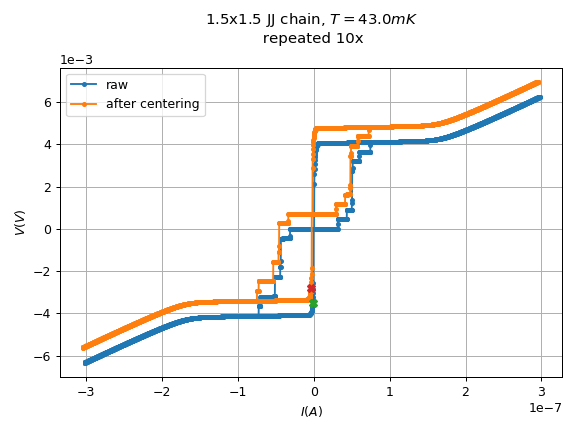

In [808]:
SAMPLE = '74N4' #6ab,9ba
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots()
# ax = ax.flatten()

T = 43e-3
for i,v in enumerate([275]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    
#     Is_off = 2.25e-9
#     Vs_off = (Vs[20]+Vs[int(len(Is)/2)])/2  
    Is_off = 2.25e-9
    Is_step= 2e-10
    Is = Is-Is_off
    Vs = Vs-(Vs[int(np.ceil(Is_off/Is_step))]+Vs[int(len(Is)/2)])/2
    
    ax.plot(Is, Vs, '.',ls='-',label = 'raw')
    ax.plot(Is-Is_off, Vs-Vs_off, '.',ls='-',label = 'after centering')
    ax.plot(Is[3], Vs[3], 'X')
    ax.plot(Is[3]-Is_off, Vs[3]-Vs_off, 'X')
    ax.set_xlabel('$I(A)$')
    ax.set_ylabel('$V(V)$')
    ax.set_title('1.5x1.5 JJ chain, $T={}K$\n repeated 10x'.format(si_format(T)), pad=20)
    ax.legend()
    ax.grid('both')
    ax.ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


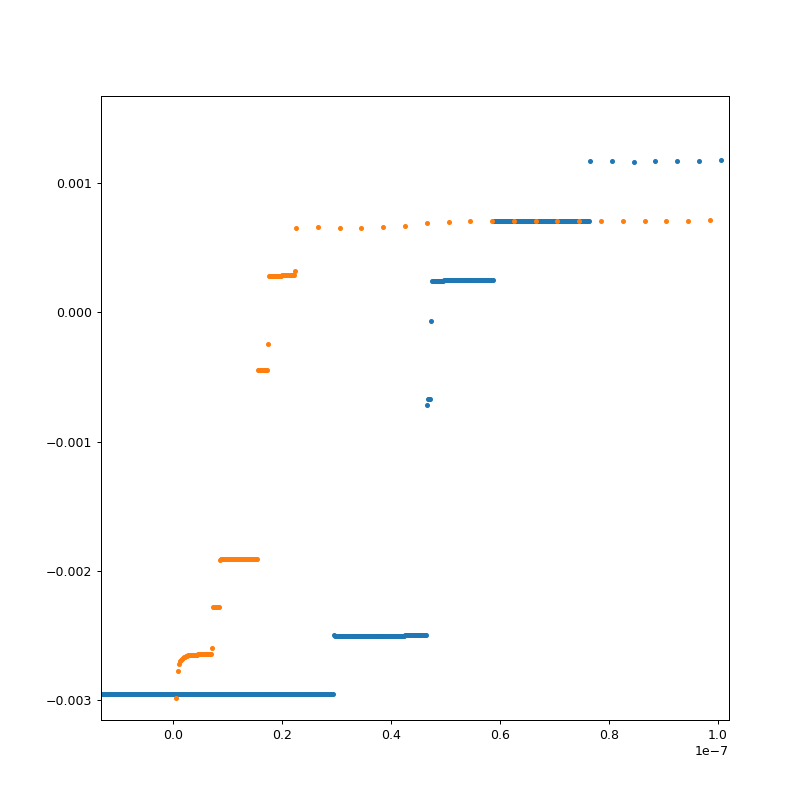

In [833]:
plt.close('all')
f,ax = plt.subplots(figsize=(9,9))

for i in [22,40]:
    IVshift = IVc_shift(get_data_by_id(i)[0][0]['data'], 
                    get_data_by_id(i)[0][1]['data'],
                    Is_off = 2.25e-9, Is_step= 2e-10)
    
    l = len(IVshift['Is'])
    ax.plot(IVshift['Is'],
            IVshift['Vs'],'.',alpha = 1)
plt.show()

<IPython.core.display.Javascript object>


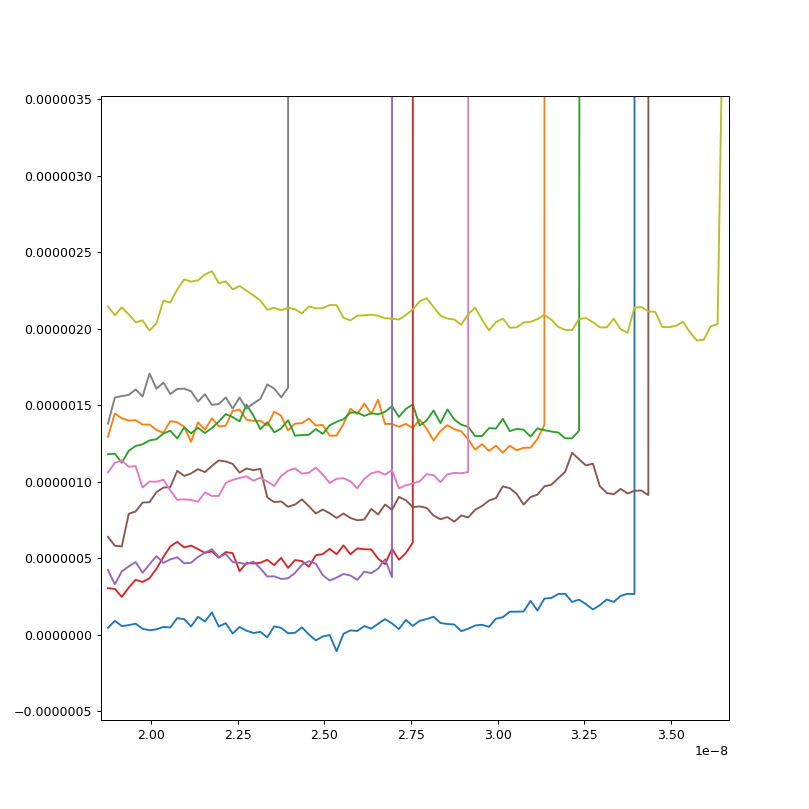

In [802]:
plt.close('all')
f,ax = plt.subplots(figsize=(9,9))

for i in range(274,283):
    IVshift = IVc_shift(get_data_by_id(i)[0][0]['data'], 
                    get_data_by_id(i)[0][1]['data'],
                    Is_off = 2.25e-9, Is_step= 2e-10)

    l = len(IVshift['Is'])
    ax.plot(IVshift['Is'][int(l/64):int(l/14)],
            IVshift['Vs'][int(l/64):int(l/14)],'-',alpha = 1)
plt.show()

In [780]:
def IVc_shift (Is, Vs, Is_off = 2.25e-9, Is_step= 2e-10):
    Is1 = Is-Is_off
    Vs1 = Vs-(Vs[int(np.ceil(Is_off/Is_step))]+Vs[int(len(Is)/2)])/2

    IVs = pd.DataFrame(data = zip(Is1,Vs1), columns = ['Is', 'Vs'])
    
    ofsInd = int(np.floor(np.abs(IVs['Is'][0])/Is_step))+1
    IVs_shift = IVs.shift(periods=-1*ofsInd)
    IVs_shift = pd.concat([IVs_shift[:-1*ofsInd], IVs[0:ofsInd]], ignore_index=True)
    maxInd = IVs_shift[IVs_shift['Is'] == IVs_shift['Is'].max()].index[0]+1
    IVs_shift = pd.concat([IVs_shift[:3*maxInd], IVs_shift[-1*maxInd-1:]])
    return IVs_shift

<IPython.core.display.Javascript object>


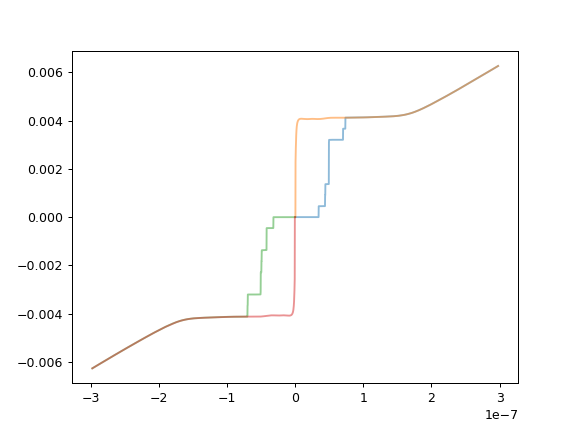

In [785]:
IVshift = IVc_shift(get_data_by_id(279)[0][0]['data'], 
                    get_data_by_id(279)[0][1]['data'],
                    Is_off = 2.25e-9, Is_step= 2e-10)

plt.close('all')
f,ax = plt.subplots()
l = len(IVshift['Is'])

for i in [0,1,2,3]:
    ax.plot(IVshift['Is'][int(l*i/4):int(l*(i+1)/4)],
            IVshift['Vs'][int(l*i/4):int(l*(i+1)/4)],'-',alpha = 0.5)
plt.show()

<IPython.core.display.Javascript object>


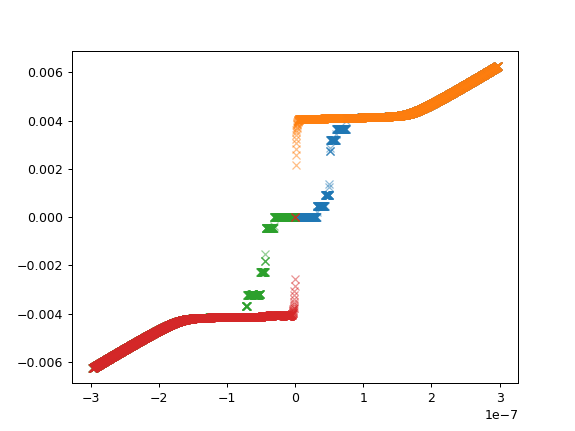

In [759]:
plt.close('all')
f,ax = plt.subplots()

data = get_data_by_id(275)
Is = data[0][0]['data']
Vs = data[0][1]['data']
Is_off = 2.25e-9
Is_step= 2e-10
Vs_off = (Vs[int(np.ceil(Is_off/Is_step))]+Vs[int(len(Is)/2)])/2
Is1 = Is-Is_off
Vs1 = Vs-Vs_off
# ax.plot(Is1[int(len(Is1)/4*0):int(len(Is1)/4*4)],
#         Vs1[int(len(Vs1)/4*0):int(len(Vs1)/4*4)])

IVs = pd.DataFrame(data = zip(Is1,Vs1), columns = ['Is', 'Vs'])
ofsInd = int(np.floor(np.abs(IVs['Is'][0])/np.round((IVs['Is'][1]-IVs['Is'][0]),15)))+1
IVs_shift = IVs.shift(periods=-1*ofsInd)
IVs_shift = pd.concat([IVs_shift[:-1*ofsInd], IVs[0:ofsInd]], ignore_index=True)

maxInd = IVs_shift[IVs_shift['Is'] == IVs_shift['Is'].max()].index[1]
IVs_shift = pd.concat([IVs_shift[:3*maxInd], IVs_shift[-1*maxInd:]])

l = len(IVs_shift)
for i in [0,1,2,3]:
    ax.plot(IVs_shift['Is'][int(l*i/4):int(l*(i+1)/4)],
            IVs_shift['Vs'][int(l*i/4):int(l*(i+1)/4)],'x',alpha = 0.5)
plt.show()

In [371]:
sku = [  122,  123,  113,  122,  123,  122,  301]
loc = [   61,   61,   62,   62,   62,   63,   63]
flag= [ True, True, True, True,False,False, True]
lst1= pd.DataFrame(data = list(zip(sku,loc,flag)), columns = ['sku', 'loc', 'flag'])
print(lst1)
sku = [  113,  122,  123,  301]
dep = [  'a',  'b',  'b',  'c']
lst2= pd.DataFrame(data = list(zip(sku,dep)), columns = ['sku', 'dep'])
print(lst2)

lst2.merge(lst1, on = 'sku', how = 'left')

   sku  loc   flag
0  122   61   True
1  123   61   True
2  113   62   True
3  122   62   True
4  123   62  False
5  122   63  False
6  301   63   True
   sku dep
0  113   a
1  122   b
2  123   b
3  301   c


,sku,dep,loc,flag
0,113,a,62,True
1,122,b,61,True
2,122,b,62,True
3,122,b,63,False
4,123,b,61,True
5,123,b,62,False
6,301,c,63,True
